# Data Visualization for Data Exploration of our Dataset

## Import Libraries

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import sys
%matplotlib inline

plt.rcParams['figure.subplot.hspace'] = 0.5
plt.rcParams['figure.figsize'] = [15, 10]

# Create DataWrapper class to manipulate the data

In [5]:
def convert_numpy_arr_to_df(np_array, classcol, label=None):
    """Convert a numpy array to a pandas DataFrame.

    Assumption about the numpy array:
        - The class column is the last one.
        - Any column with an index greater than classcol will be ignored.

    :param numpy.array np_array: Numpy array to convert.
    :param int classcol: The index of the class column.
    :param dict label: Dictionary containing the replacement labels. (Default None)
    """

    df = pd.DataFrame(
            data=np_array,
            columns=[f'p{int(p / 4)}_sp{p % 4}'
                     for p in range(classcol)] + ['Class']
            )
    df['Class'] = df['Class'].astype(int)
    if label is not None:
        df['Class'] = df['Class'].replace(label)
    return df


In [6]:
import numpy as np
from sklearn import preprocessing


class DataWrapper:
    def __init__(self, train_set=None, test_set=None, label=None):
        if label is None:
            self.label = {1: 'RedS',
                          2: 'CottonC',
                          3: 'GreyS',
                          4: 'DampGreyS',
                          5: 'SoilVeg',
                          6: 'Mixture',
                          7: 'VeryDampGreyS'}
        else:
            self.label = label
        self.train_set = convert_numpy_arr_to_df(train_set, 36, self.label)
        self.test_set = convert_numpy_arr_to_df(test_set, 36, self.label)

    def import_train_set_from_txt(self, path_train):
        """Import the training set from a text file.

        :param str path_train: Path to the text file containing the training set.
        """

        self.train_set = convert_numpy_arr_to_df(np.loadtxt(path_train), 36, self.label)

    def import_test_set_from_txt(self, path_test):
        """Import the testing set from a text file.

        :param str path_test: Path to the text file containing the testing set.
        """

        self.test_set = convert_numpy_arr_to_df(np.loadtxt(path_test), 36, self.label)

    def import_train_set(self, train_set):
        """Import the training set from a numpy.array.

        :param numpy.array train_set: Matrix containing the training data.
        """

        self.train_set = convert_numpy_arr_to_df(train_set, 36, self.label)

    def import_test_set(self, test_set):
        """Import the testing set from a numpy.array.

        :param numpy.array test_set: Matrix containing the testing data.
        """

        self.test_set = convert_numpy_arr_to_df(test_set, 36, self.label)

    def apply_scaler(self, scaler):
        self.unscaled_train_set = self.train_set
        self.unscaled_test_set = self.test_set
        self.train_set.iloc[:, :36] = scaler.fit_transform(self.train_set.iloc[:, :36])
        self.test_set.iloc[:, :36] = scaler.fit_transform(self.test_set.iloc[:, :36])

    def scale(self, scaler_type="standard", **kwargs):
        scaler = None
        if scaler_type == "standard":
            scaler = preprocessing.StandardScaler(**kwargs)
        elif scaler_type == "minmax":
            scaler = preprocessing.MinMaxScaler(**kwargs)
        elif scaler_type == "normalize":
            scaler = preprocessing.Normalizer(**kwargs)
        self.apply_scaler(scaler)

    def get_features(self, train=True):
        if train:
            return self.train_set.iloc[:, :36]
        else:
            return self.test_set.iloc[:, :36]

    def get_targets(self, train=True):
        if train:
            return self.train_set.iloc[:, 36]
        else:
            return self.test_set.iloc[:, 36]

In [7]:
def get_datawrapper(path_trn="flaskapp/flaskr/static/data/sat.trn", path_tst="flaskapp/flaskr/static/data/sat.tst", scale="none"):
    data = DataWrapper()
    data.import_train_set_from_txt(path_trn)
    data.import_test_set_from_txt(path_tst)
    if scale != "none":
        data.scale(scale)
    return data

In [8]:
data = get_datawrapper()

### Plot Spectrum

In [62]:
def plot_spectrum(data, pixel_index=4, spectrum_index=range(4), train=True, **kwargs):
    """Plot the histogram of a specified data set.

    :param int pixel_index: Index corresponding to the pixel position in the 3x3 matrix. (Default 4)
    :param iterable spectrum_index: Indexes corresponding to the spectrum index. (Default range(4))
    :param bool train: Boolean specifying whether to use training or testing set. (Default True)
    :param dict **kwargs: Dictionary of keyword arguments sent to the seaborn plot function.
    """

    query_df = None
    if train:
        query_df = data.train_set[[f'p{pixel_index}_sp{sp}' for sp in spectrum_index]]
    else:
        query_df = data.test_set[[f'p{pixel_index}_sp{sp}' for sp in spectrum_index]]
    counts = [query_df[col].astype(int).value_counts() for col in query_df.columns]
    for i in range(len(counts)):
        counts[i] = [counts[i][j] if j in counts[i] else 0 for j in range(256)]
    df = pd.DataFrame(dict(zip([f'p{pixel_index}_sp{sp}'
                                for sp in spectrum_index], counts)))
    max_pixel_value = int(max(query_df.max())) + 1
    df['Pixel Value'] = range(256)
    palette = ['green', 'red', 'orange', 'navy']
    palette = palette[:len(spectrum_index)]
    ax = sns.lineplot(x='Pixel Value', y='value', hue='variable', data=pd.melt(df, ['Pixel Value']), **kwargs)
    ax.set(xlim=(0, max_pixel_value))
    return ax

<AxesSubplot:xlabel='Pixel Value', ylabel='value'>

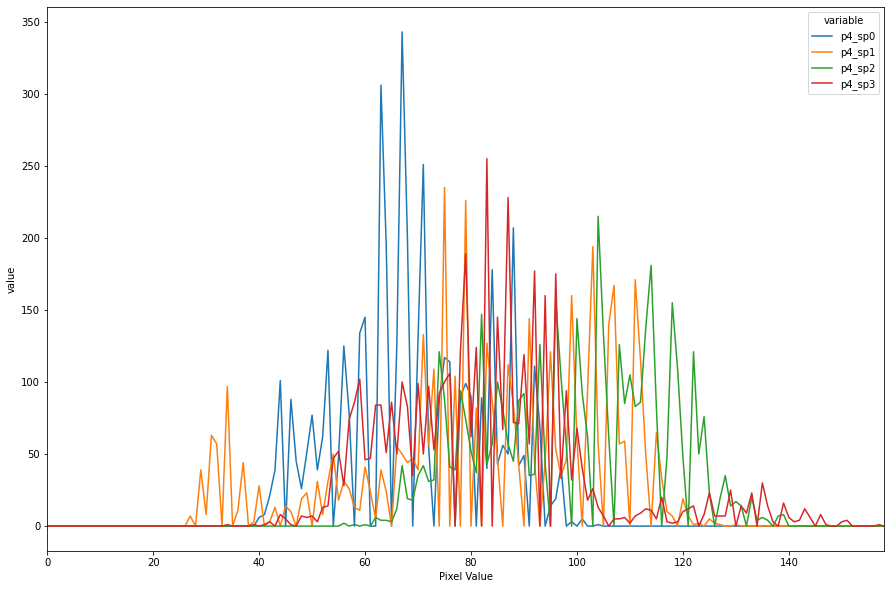

In [63]:
plot_spectrum(data)

### Plot spectrum by pixel index

In [64]:
def plot_spectrum_by_pixel_index(data, spectrum_index=range(4), train=True, **kwargs):
    fig, axs = plt.subplots(3, 3)
    for i in range(3):
        for j in range(3):
            plot_spectrum(data,
                          i * 3 + j,
                          spectrum_index,
                          train=train,
                          ax=axs[i, j],
                          **kwargs)
    return fig

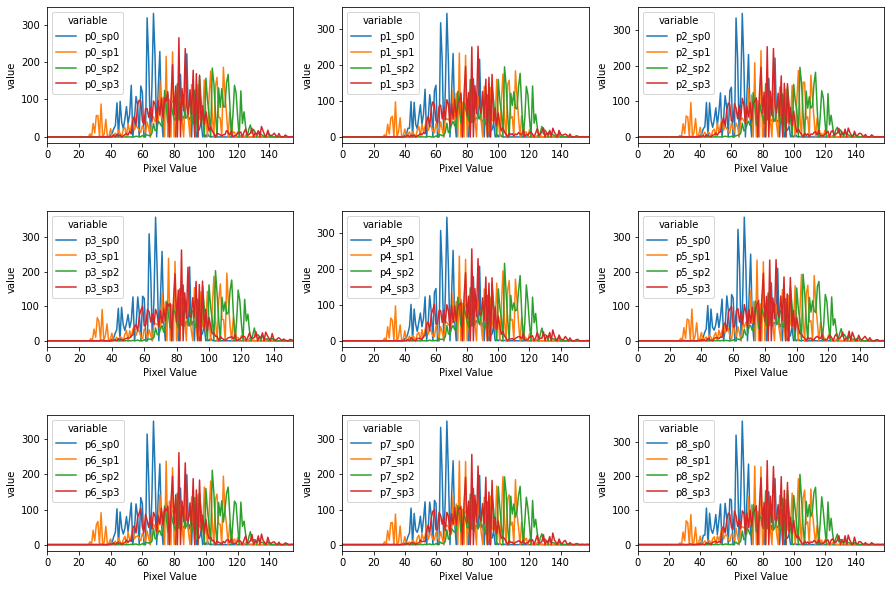

In [65]:
fig = plot_spectrum_by_pixel_index(data)

### Plot pixel value 

In [66]:
def plot_pixel_value(data, pixel_index=range(9), spectrum_index=range(4), train=True, labels=True, **kwargs):
    """Plot the pixel value in function of the pixel position and the spectrum.

    :param iterable pixel_index: Indexes corresponding to the pixels position in the 3x3 matrix. (Default range(9))
    :param iterable spectrum_index: Indexes corresponding to the spectrum index. (Default range(4))
    :param bool train: Boolean specifying whether to use training or testing set. (Default True)
    :param bool labels: Boolean specifying whether to display title and axes labels or not. (Default True)
    :param dict **kwargs: Dictionary of keyword arguments sent to the seaborn plot function.
    """

    df = data.train_set if train else data.test_set
    classes = df['Class'].tolist() * len(pixel_index)
    pixel_index = [p * 4 for p in pixel_index]
    means = []
    pixel_position = []
    for p in pixel_index:
        temp = df.iloc[:, [p + s for s in spectrum_index]].mean(axis=1)
        means.extend(temp.tolist())
        pixel_position.extend([int(p / 4) for i in range(len(df))])
    ax = sns.stripplot(x=classes, y=means, hue=pixel_position, **kwargs)
    if labels:
        ax.set(xlabel='Class',
               ylabel='Pixel Value',
               title='Plot of classes by pixel value and pixel position.')
    ax.legend(title='Pixel position')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.legend(loc='upper left')
    return ax

<AxesSubplot:title={'center':'Plot of classes by pixel value and pixel position.'}, xlabel='Class', ylabel='Pixel Value'>

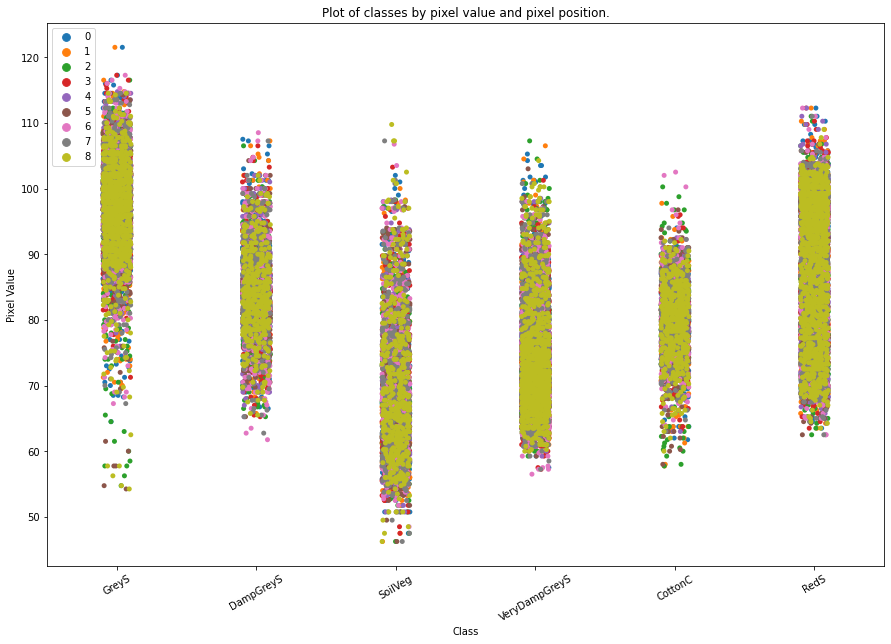

In [67]:
plot_pixel_value(data)

### Plot pixel value by pixel index

In [68]:
def plot_pixel_value_by_pixel_index(data, spectrum_index=range(4)):
    """Plot side by side the pixel value in function of the pixel position.

    :param iterable spectrum_index: Indexes corresponding to the spectrum index. (Default range(4))
    """

    fig, axs = plt.subplots(3, 3)
    palette = sns.color_palette('husl', 9)
    for i in range(3):
        for j in range(3):
            plot_pixel_value(data,
                             [i * 3 + j],
                             spectrum_index,
                             labels=False,
                             ax=axs[i, j],
                             palette=[palette[i * 3 + j]])
    return fig

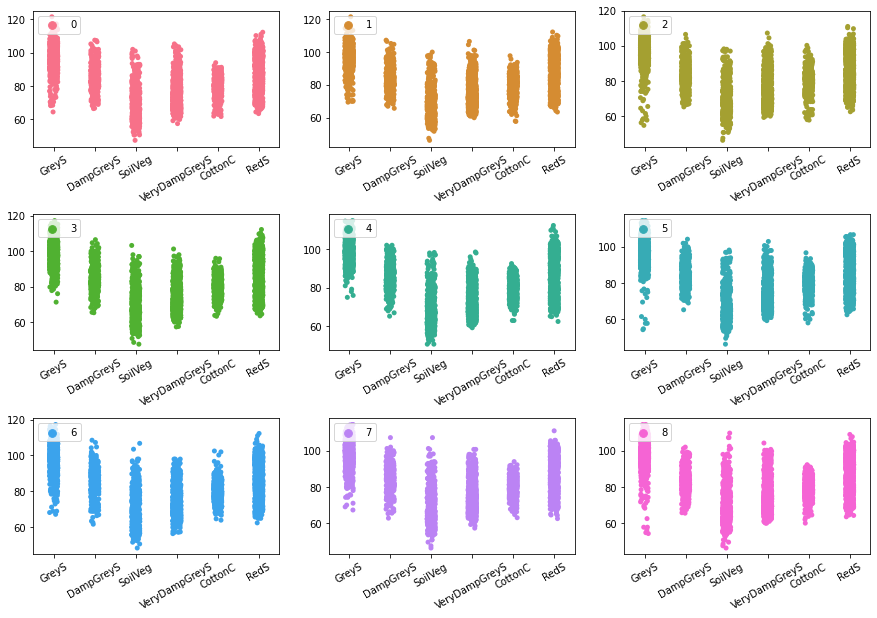

In [69]:
fig = plot_pixel_value_by_pixel_index(data)

### Pixel value by spectrum index

In [75]:
def plot_pixel_value_by_spectrum_index(data, pixel_index=range(9)):
    """Plot side by side the pixel value in function of the spectrum index

    :param iterable pixel_index: Indexes corresponding to the pixels position in the 3x3 matrix. (Default range(9))
    """

    fig, axs = plt.subplots(2, 2)
    for i in range(2):
        for j in range(2):
            plot_pixel_value(data, pixel_index, [i * 2 + j], labels=False, ax=axs[i, j])
    return fig

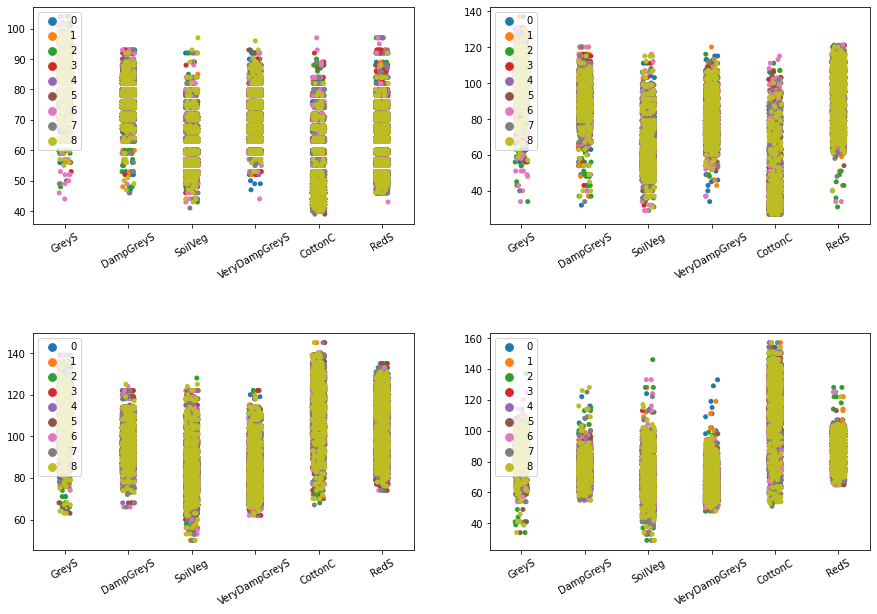

In [76]:
fig = plot_pixel_value_by_spectrum_index(data)

### Bar Plots of classes

In [9]:
def plot_bar_class(data, train=True):
    """Bar plot the number of observations by class.

    :param bool train: Boolean indicating whether to use the training or testing set. (Default True)
    """

    counts = data.train_set['Class'].value_counts() if train else data.test_set['Class'].value_counts()
    for i in data.label.values():
        if i not in counts.index:
            counts.at[i] = 0
    ax = sns.barplot(x=counts.index, y=counts)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.set(xlabel='Label',
           ylabel='No. of pixels labelled',
           title='Bar Plot of classes')
    return ax

<AxesSubplot:title={'center':'Bar Plot of classes'}, xlabel='Label', ylabel='No. of pixels labelled'>

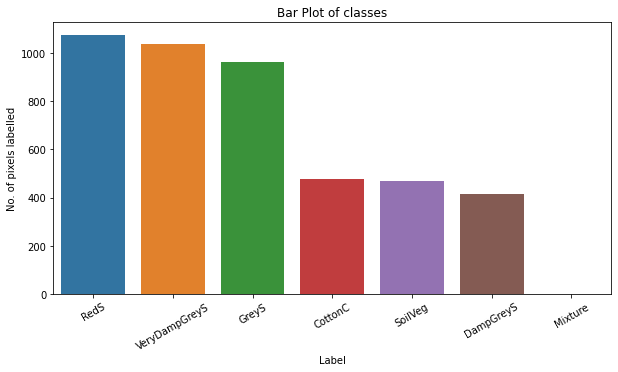

In [12]:
plt.rcParams['figure.figsize'] = [10, 5]
plot_bar_class(data=data)

## Principal Component Analysis (PCA)

In [23]:
def get_pca(data, train=True, number_components=5):
    """Build and return a sklearn.decomposition.PCA object applied on the specified data set.

    source: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

    :param bool train: Wheter to use training set or testing set. (Default True)
    :param int number_components: Number of components used in the pca. (Default 5)
    """

    df = data.train_set if train else data.test_set

    # Store the features values
    df_features = df.iloc[:, 0:36].values
    # Store the class values

    # Scale the features
    df_features = StandardScaler().fit_transform(df_features)

    # Apply PCA on features
    pca = PCA(n_components=number_components)
    principal_components = pca.fit_transform(df_features)
    return pca, principal_components

### Plot the explained variance from the PCA

In [24]:
def plot_explained_variance(data, pca):
    """Plot the graph of explained variance.

    :param sklearn.decomposition.PCA pca: PCA object to plot the explained variance from.
    """

    ax = plt.subplot()
    ax.bar(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_)
    ax.set_ylabel('Explained variance')
    ax.set_xlabel('Components')
    ax.set_title('Explained variance Plot')
    ax.plot(range(1, len(pca.explained_variance_) + 1),
            np.cumsum(pca.explained_variance_),
            c='red',
            label='Cumulative Explained Variance'
            )
    plt.legend(loc='upper left')
    plt.tight_layout()
    return ax

<AxesSubplot:title={'center':'Explained variance Plot'}, xlabel='Components', ylabel='Explained variance'>

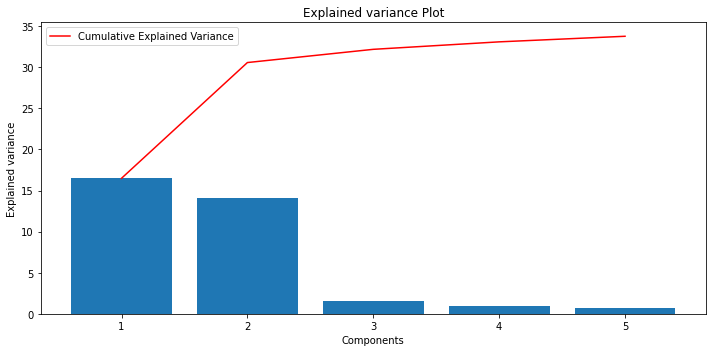

In [25]:
pca, principal_comp = get_pca(data)
plot_explained_variance(data,pca)

### Scree plot of the PCA

In [26]:
def plot_scree(data, pca):
    """Plot the scree graph of a PCA.

    :param sklearn.decomposition.PCA pca: PCA object to plot the scree graph from.
    """

    ax = plt.subplot()
    ax.plot(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_)
    ax.set_xlabel('Number of components')
    ax.set_ylabel('Cumulative explained variance')
    plt.tight_layout()
    return ax

<AxesSubplot:xlabel='Number of components', ylabel='Cumulative explained variance'>

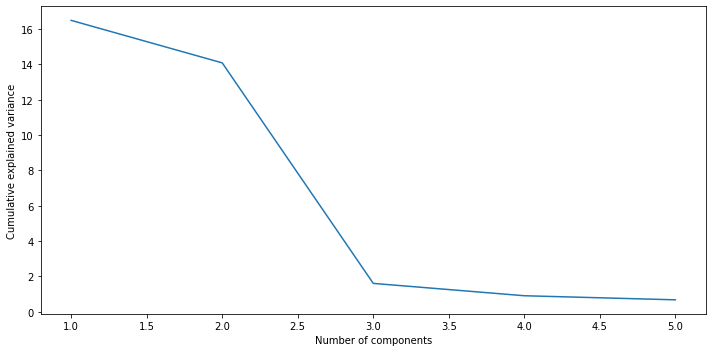

In [27]:
plt.rcParams['figure.figsize'] = [10, 5]
plot_scree(data,pca)

### 2D visualization of the PCA

In [132]:
def plot_pca(data, pca, principal_components, train=True):
    """Plot the 2D visualization of a pca.

    :param sklearn.decomposition.PCA pca: PCA object to plot from.
    :param pandas.DataFrame principal_components: Principal components of the pca.
    :param bool train: Boolean indicating whether to use the training or testing set. (Default True)
    """
    
    classes = data.get_targets(train)
    # Store the PCA values in a DataFrame
    principal_comp_df = pd.DataFrame(data=principal_components,
                                     columns=[f'PC{i}' for i in range(1, pca.n_components_ + 1)])

    # Add the target values and rename it
    final_df = pd.concat([principal_comp_df, classes], axis=1)
    final_df = final_df.rename(columns={36:"Class"})

    # 2D projection
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('Principal Component 1', fontsize=15)
    ax.set_ylabel('Principal Component 2', fontsize=15)
    ax.set_title('PCA with 2 Components', fontsize=20)

    targets = list(data.label.values())

    # Colors for our different labels
    colors = ['crimson',
              'bisque',
              'silver',
              'dimgrey',
              'limegreen',
              'royalblue',
              'blueviolet']

    # We plot with only the two first components
    for target, color in zip(targets, colors):
        indices_to_keep = final_df['Class'] == target
        ax.scatter(final_df.loc[indices_to_keep, 'PC1'],
                   final_df.loc[indices_to_keep, 'PC2'],
                   c=color,
                   s=50)

    ax.legend(targets)
    ax.grid()
    plt.tight_layout()
    return ax

<AxesSubplot:title={'center':'PCA with 2 Components'}, xlabel='Principal Component 1', ylabel='Principal Component 2'>

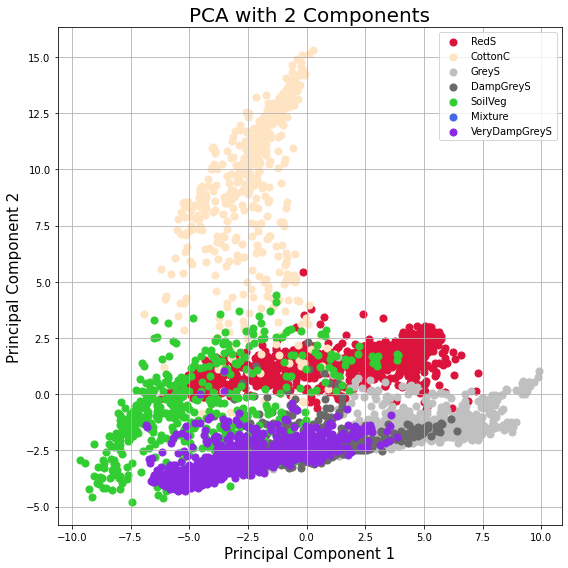

In [133]:
plot_pca(data,pca,principal_comp)